<a href="https://colab.research.google.com/github/adasegroup/ML2023_seminars/blob/master/seminar9/seminar_feature_model_selection_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature selection

A good grasp of feature selection methods leads to better performing models, better understanding of the underlying structure and characteristics of the data and leads to better intuition about the algorithms that underlie many machine learning models.

There are in general two reasons why feature selection is used:
1. Reducing the number of features, to reduce overfitting and improve the generalization of models.
2. To gain a better understanding of the features and their relationship to the response variables.

In some cases a model may become more interpretable.

### Toy function


$$
y = \sin (4\pi x_1 x_2) + 4(x_3 - 0.5)^2 + x_4 + 0.5 x_5 + \varepsilon,
$$
where 

* $x_1, \ldots, x_5 \sim Uniform([0, 1])$ and $\varepsilon \sim \mathcal{N}(0, 1)$.
* We also add noise variables $x_6, x_7, x_8$
* and  $x_9, x_{10}, x_{11}$ strongly correlated with $x_2, x_3, x_4$ generated by $f(x) = x + \mathcal{N}(0, 025)$.


In [4]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


def function(x, sigma_noise=1, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(1337)
    y = (np.sin(4 * np.pi * x[:, 0] * x[:, 1])
         + 4 * (x[:, 2] - 0.5)**2
         + x[:, 3]
         + 0.5 * x[:, 4]
         + random_state.normal(0, sigma_noise, size=(len(x)))
        )
    return y

Let's generate training, validation and test sets

In [5]:
from sklearn.model_selection import train_test_split

np.random.seed(1377)
random_state = np.random.RandomState(1377)
size = 1500
X = random_state.rand(size, 11)
y = function(X, sigma_noise=0.01, random_state=random_state) 

#Add 3 additional correlated variables (correlated with X1-X3)
X[:, 8:] = X[:, 1:4] + random_state.normal(0, .025, size=(size, 3))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=random_state)
print(X_train.shape, X_val.shape, X_test.shape)

(735, 11) (315, 11) (450, 11)


## F-test based feature importances

Consider two models, $M_1$ and $M_2$, where $M_1$ has $p_1$ parameters and $M_2$ has $p_2$ parameters,
and $p_2 > p_1$,
parameters of $M_1$ are subset of parameters of $M_2$.

* We want to check whether $M_2$ significantly better than $M_1$
* Let us consider the value
$$
    F=\frac{\left({\frac {{\text{RSS}}_{1}-{\text{RSS}}_{2}}{p_{2}-p_{1}}}\right)}
           {\left({\frac {{\text{RSS}}_{2}}{n-p_{2}-1}}\right)},
$$ 
where $RSS_i$ is the Residual Sum of Squares of $M_i$.  

* If $M_2$ is not significantly better than $M_1$, $F$ will have an F-distribution, with $(p_2−p_1, n−p_2)$ degrees of freedom.
* We rejecte the hypothesis if the $F$ value is greater than the critical value of the F-distribution for some desired false-rejection probability (e.g. 0.05).


* Relies on $\mathbf{\color{orange}{\mbox{linearity}}}$ of models $M_1, M_2$

Now, let's apply F-test to the generated data and analyze results

In [6]:
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd


feature_names = np.array(
    ['x1 [sin(x1 x2)]', 'x2 [sin(x1 x2)]', 'x3 [x3^2]', 'x4', 'x5',
     'noise1', 'noise2', 'noise3',
     'corr(x2)', 'corr(x3)', 'corr(x4)'])

feature_scores = pd.DataFrame(columns=['F test'], index=feature_names)

feature_scores['F test'], _ = f_regression(X_train, y_train)

scaler = MinMaxScaler()
feature_scores['F test'] = scaler.fit_transform(feature_scores[['F test']])
feature_scores.style.format(precision=2).background_gradient(cmap='Reds', high=1.01)

,F test
x1 [sin(x1 x2)],0.23
x2 [sin(x1 x2)],0.18
x3 [x3^2],0.00
x4,1.00
x5,0.15
noise1,0.00
noise2,0.00
noise3,0.01
corr(x2),0.19
corr(x3),0.00


**Conclusion**: F-test captures well only linear dependencies!

### Mutual Information

This method estimates how much information about the target variable $Y$ is contained in the feature $X$.  
To do this we calculate the value
$$
MI(X, Y) = H(Y) - H(Y | X) = \sum_{x, y} p(x, y) \log \frac{p(x, y)}{p(x)p(y)} = D_{KL}(p(x, y) \, ||  \, p(x)p(y)),
$$
where $p(x, y), p(x), p(y)$ are joint and marginal densities of random variables $X$ and $Y$.

* $MI(X, Y) = 0 \Leftrightarrow $ $X$ and $Y$ are independent
* Higher values $\rightarrow$ higher dependency
* Can capture $\mathbf{\color{green}{\mbox{non-linear}}}$ dependcies

#### Let's compare F-test and Mutual Information

In [7]:
from sklearn.feature_selection import mutual_info_regression


method_name = 'Mutual Information'
feature_scores[method_name] = mutual_info_regression(X_train, y_train)

feature_scores[method_name] = scaler.fit_transform(feature_scores[[method_name]])
feature_scores.style.format(precision=2).background_gradient(cmap='Reds', high=1.01)

,F test,Mutual Information
x1 [sin(x1 x2)],0.23,0.75
x2 [sin(x1 x2)],0.18,0.81
x3 [x3^2],0.00,1.00
x4,1.00,0.60
x5,0.15,0.05
noise1,0.00,0.00
noise2,0.00,0.15
noise3,0.01,0.28
corr(x2),0.19,0.89
corr(x3),0.00,0.61


**Conclusion**: better estimate for non-linear dependencies

## Random Forest based feature importances
Random forests provide straightforward methods for feature ranking

* The importance of a feature is the (normalized) total reduction of the criterion brought by that feature:
    * For each split in a tree get how much it decreases Gini index.
    * Take sum of this values over all splits of the feature over all trees

In [8]:
from sklearn.ensemble import RandomForestRegressor 

random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

feature_scores['Random Forest'] = scaler.fit_transform(random_forest.feature_importances_.reshape(-1, 1))
feature_scores.style.format(precision=2).background_gradient(cmap='Reds', high=1.01)

,F test,Mutual Information,Random Forest
x1 [sin(x1 x2)],0.23,0.75,1.00
x2 [sin(x1 x2)],0.18,0.81,0.63
x3 [x3^2],0.00,1.00,0.59
x4,1.00,0.60,0.50
x5,0.15,0.05,0.23
noise1,0.00,0.00,0.07
noise2,0.00,0.15,0.00
noise3,0.01,0.28,0.07
corr(x2),0.19,0.89,0.22
corr(x3),0.00,0.61,0.32


## L1 and L2 regularizations

Regularization adds penalty to a model in order to prevent overfitting and improve generalization.  

* Instead of minimizing a loss function $L(X,Y)$, we minimize $L(X,Y)+\alpha\|w\|$,
    * where $w$ is the vector of model coefficients,
    * $\|\cdot\|$ is typically L1 or L2 norm
    * $\alpha$ is a parameter, specifying the amount of regularization ($\alpha = 0$ implies no regularization).
* **Lasso** - linear model with L1 regularization.
* **RidgeRegression** - linear model with L2 regularization
* **Lasso** efficiently **zeros out** coefficients, RidgeRegression makes them smaller but typically non-zero.
* $\rightarrow$ Lasso can be used for feature selection

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso, Ridge

lasso = make_pipeline(StandardScaler(with_mean=False), Lasso(alpha=0.001)).fit(X_train, y_train)
feature_scores['Lasso'] = scaler.fit_transform(np.abs(lasso['lasso'].coef_).reshape(-1, 1))

ridge = make_pipeline(StandardScaler(with_mean=False), Ridge()).fit(X_train, y_train)
feature_scores['Ridge'] = scaler.fit_transform(np.abs(ridge['ridge'].coef_).reshape(-1, 1))
feature_scores.style.format(precision=2).background_gradient(cmap='Reds', high=1.01)

,F test,Mutual Information,Random Forest,Lasso,Ridge
x1 [sin(x1 x2)],0.23,0.75,1.00,0.73,0.44
x2 [sin(x1 x2)],0.18,0.81,0.63,0.00,0.48
x3 [x3^2],0.00,1.00,0.59,0.98,0.99
x4,1.00,0.60,0.50,0.60,0.38
x5,0.15,0.05,0.23,0.59,0.36
noise1,0.00,0.00,0.07,0.00,0.00
noise2,0.00,0.15,0.00,0.07,0.04
noise3,0.01,0.28,0.07,0.05,0.03
corr(x2),0.19,0.89,0.22,0.81,0.98
corr(x3),0.00,0.61,0.32,1.00,1.00


### Task

What if we remove correlated component?

**Task**: 
1. Build `RidgeRegression` model using all features. Check coefficients for features `x4` and `corr(x4)`.
2. Build `RidgeRegression` model without the last features. Check coefficient for feature `x4`.
3. What can you conclude?

In [10]:
# Your code here
model = make_pipeline(StandardScaler(with_mean=False), Ridge()).fit(X_train[:, :-1], y_train)
print(scaler.transform(np.abs(model['ridge'].coef_[[3]]).reshape(-1, 1)))

model = make_pipeline(StandardScaler(with_mean=False), Ridge()).fit(X_train, y_train)
print(scaler.transform(np.abs(model['ridge'].coef_[[3, -1]]).reshape(-1, 1)))

[[0.8874144]]
[[0.37929399]
 [0.50979485]]


## Forward-backward methods

The idea is to add or delete features and look how loss function or some other criteria changes.

Decision about adding or deleting a feature may be made based on:

- AIC
- BIC
- validation error
- Mallows $C_p$
- `model.score()`

### Task. Implement forward method

Implement the following algorithm:

1. Start with empty list of features.
2. Add feature that increases model quality the most (use `model.score()` function)
3. Iterate step 2 until required number of features is selected


In [11]:
def forward_steps(X, y, n_features, model, X_test, y_test):
    """
    Parameters
    ==========
        X: ndarray - training inputs
        y: ndarray - training targets
        n_features: int - number of features to select
        model: sklearn model
        X_test: ndarray - test inputs
        y_test: ndarray - test targets
        
    Returns
    =======
        list - list of features
    """
    
    feat_list = []
    
    # Your code here
    
    # fill variable feat_list with
    # the selected features and return it
    
    for i in range(n_features):
        max_score = -np.inf
        active_idx = -1
        for j in range(X.shape[1]):
            if j not in feat_list:
                feat_list.append(j)
                
                model.fit(X[:, feat_list], y)
                current_score = model.score(X_test[:, feat_list], y_test)

                feat_list.pop()

                if current_score > max_score:
                    max_score = current_score
                    active_idx = j
        feat_list.append(active_idx)
        
        print('{:.2f}: {}'.format(max_score, feat_list))
    return feat_list

In [12]:
features_idx = forward_feat = forward_steps(X_train, y_train, 5,
                                            random_forest,
                                            X_test, y_test)
print(feature_names[features_idx])

-0.18: [3]
0.17: [3, 1]
0.71: [3, 1, 0]
0.70: [3, 1, 0, 8]
0.70: [3, 1, 0, 8, 9]
['x4' 'x2 [sin(x1 x2)]' 'x1 [sin(x1 x2)]' 'corr(x2)' 'corr(x3)']


## Permutation based feature importance


**Idea**: measure how much the score (accuracy, F1, R^2, etc.) decreases when a feature is not available.

It can be done by:

* Removing feature from the dataset, re-training the estimator and check the score - can be $\mathbf{\color{orange}{\mbox{computationally intensive}}}$

* Replace feature with random noise - now the column doesn't contain useful information.
  
  * Noise should be from the same distribution as original feature values (as otherwise estimator may fail).
  * -> $\mathbf{\color{blue}{\mbox{shuffle values for a feature}}}$, i.e. use other examples’ feature values
  * Allows to estimate feature importance for generalization on new data set

To do that one can remove feature from the dataset, re-train the estimator and check the score. But it requires re-training an estimator for each feature, which can be computationally intensive. Also, it shows what may be important within a dataset, not what is important within a concrete trained model.


The method is most suitable for computing feature importances when a number of columns (features) is not huge; it can be resource-intensive otherwise.

### Task. Implement permutation importance

1. Using fitted model calculate its base_score - score, obtained using all features
2. Take one feature column and replace its values by the permuted values, calculate
   the score and subtract it from base_score, i.e. calculate `score_decrease`
3. Repeat step 2 several times and calculte mean `score_decrease`
4. Do steps 2 and 3 for each feature

In [13]:
def _permutation_importance(model, X, y, 
                            feature, n_iters=5, random_state=None):
    """
    Calculate permutation importances for the given feature
    
    Parameters
    ==========
        model: sklearn-style fitted model with and score() methods
        X: ndarray - training inputs
        y: ndarray - training targets
        feature: int - index of feature for which importance should be
                       calculated
        n_iters: int - number of permutation rounds
        
    Returns
    =======
        ndarray: feature importances
    """
    if random_state is None:
        random_state = np.random.RandomState(42)
    if isinstance(random_state, int):
        random_state = np.random.RandomState(random_state)

    base_score = model.score(X, y)
    
    importance = None
    
    scores = []
    for i in range(n_iters):
        X_copy = X.copy()
        permutation = random_state.permutation(X.shape[0])
        X_copy[:, feature] = X[permutation, feature]
            
        scores.append(base_score - model.score(X_copy, y))
        
    importance = np.mean(scores)

    return importance

def get_permutation_importance(model, X, y, n_iters=20, random_state=None):
    permutation_importances = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
        permutation_importances[i] = _permutation_importance(model, X_val, y_val, i)
    return permutation_importances

In [14]:
random_forest = RandomForestRegressor(n_estimators=100).fit(X_train, y_train)
permutation_importances = get_permutation_importance(random_forest, X_val, y_val)

feature_scores['Permutation Importance'] = scaler.fit_transform(permutation_importances.reshape(-1, 1))
feature_scores.style.format(precision=2).background_gradient(cmap='Reds', high=1.01)

,F test,Mutual Information,Random Forest,Lasso,Ridge,Permutation Importance
x1 [sin(x1 x2)],0.23,0.75,1.00,0.73,0.44,1.00
x2 [sin(x1 x2)],0.18,0.81,0.63,0.00,0.48,0.50
x3 [x3^2],0.00,1.00,0.59,0.98,0.99,0.26
x4,1.00,0.60,0.50,0.60,0.38,0.12
x5,0.15,0.05,0.23,0.59,0.36,0.05
noise1,0.00,0.00,0.07,0.00,0.00,0.02
noise2,0.00,0.15,0.00,0.07,0.04,0.01
noise3,0.01,0.28,0.07,0.05,0.03,0.00
corr(x2),0.19,0.89,0.22,0.81,0.98,0.21
corr(x3),0.00,0.61,0.32,1.00,1.00,0.07


It is useful to visualize feature importances using bar plot

In [15]:
def plot_feature_scores(X, scores):
    sorting_idx = scores.argsort()

    plt.figure(figsize=(10, 0.3 * len(scores)))
    plt.barh(range(len(scores)), scores[sorting_idx], height=0.5)
    plt.yticks(range(len(scores)), X.columns[sorting_idx])
    for i, v in enumerate(scores[sorting_idx]):

        if np.isfinite(v):
            v_str = '{:.3f}'.format(v) if v != int(v) else '{}'.format(int(v))
            plt.text(v + 0.005 * scores.max(), i - 0.22, v_str)
    plt.grid(True)
    plt.ylim([-0.5, len(scores) - 0.5])
    plt.show()

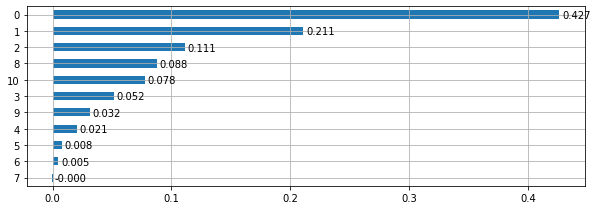

In [16]:
plot_feature_scores(pd.DataFrame(X_train), permutation_importances)

### Task 2. Use RFECV to get optimal number of features

To choose number of features automatically, RFECV module may be used.

In [17]:
from sklearn.feature_selection import RFECV

# use RFECV to select features, use step = 50
rfe = RFECV(random_forest, n_jobs=-1, verbose=True, step=1, cv=3)
rfe.fit(X_train, y_train)

feature_scores['RFECV'] = scaler.fit_transform(-rfe.ranking_.astype(float).reshape(-1, 1))
feature_scores.style.format(precision=2).background_gradient(cmap='Reds', high=1.01)

Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.


,F test,Mutual Information,Random Forest,Lasso,Ridge,Permutation Importance,RFECV
x1 [sin(x1 x2)],0.23,0.75,1.00,0.73,0.44,1.00,1.00
x2 [sin(x1 x2)],0.18,0.81,0.63,0.00,0.48,0.50,1.00
x3 [x3^2],0.00,1.00,0.59,0.98,0.99,0.26,1.00
x4,1.00,0.60,0.50,0.60,0.38,0.12,1.00
x5,0.15,0.05,0.23,0.59,0.36,0.05,0.43
noise1,0.00,0.00,0.07,0.00,0.00,0.02,0.29
noise2,0.00,0.15,0.00,0.07,0.04,0.01,0.00
noise3,0.01,0.28,0.07,0.05,0.03,0.00,0.14
corr(x2),0.19,0.89,0.22,0.81,0.98,0.21,0.71
corr(x3),0.00,0.61,0.32,1.00,1.00,0.07,0.57


In [18]:
# output selected number of features
print("Number selected features =", np.sum(rfe.support_))

Number selected features = 4


### Task. Calculate quality of the model with the selected features


* Use RandomForestRegression
* Use test set and model's `score()` function to calculate model error
* Try F-test, RandomForest embedded feature importances, Permutation Importance and RFECV
* Select 5 features for each feature importance method

In [19]:
def compare_methods(model, X_train, y_train, X_val, y_val, X_test, y_test):
    methods = {
        'F test': lambda X, y, X_val, y_val: f_regression(X, y)[0],

        'RandomForest': lambda X, y, X_val, y_val: model.fit(X, y).feature_importances_,

        'PermutationImportance': lambda X, y, X_val, y_val: get_permutation_importance(
            model.fit(X, y), X_val, y_val),

        'RFECV': lambda X, y, X_val, y_val: -RFECV(
            model, n_jobs=-1, step=1, cv=3).fit(X, y).ranking_
    }

    model_scores = pd.DataFrame(columns=list(methods.keys()))

    for fs_method in methods:
        scores = methods[fs_method](X_train, y_train, X_val, y_val)
        features_idx = np.argsort(-scores)[:5]
        model.fit(X_train[:, features_idx], y_train)
        model_scores[fs_method] = [model.score(X_test[:, features_idx], y_test)]
        
    return model_scores

In [20]:
compare_methods(random_forest, X_train, y_train, X_val, y_val, X_test, y_test)

,F test,RandomForest,PermutationImportance,RFECV
0,0.695642,0.671652,0.684606,0.665363


In [21]:
results = [compare_methods(random_forest, X_train, y_train, X_val, y_val, X_test, y_test) for _ in range(10)]

In [22]:
pd.concat(results, axis=0, ignore_index=True).describe()

,F test,RandomForest,PermutationImportance,RFECV
count,10.000000,10.000000,10.000000,10.000000
mean,0.685303,0.668247,0.691543,0.668356
std,0.005303,0.006670,0.005445,0.007170
min,0.677434,0.655519,0.678352,0.657207
25%,0.681019,0.664220,0.690316,0.663422
50%,0.685663,0.668856,0.692383,0.668345
75%,0.688375,0.672991,0.694061,0.673811
max,0.694695,0.677612,0.699261,0.680123


### Akaike Information criterion (AIC)

Suppose that we have a statistical model of some data. Let $k$ be the number of estimated parameters in the model.
Let $\hat{L}$ be the maximum value of the likelihood function for the model.
Then the AIC value of the model is the following.

$$
\mathrm {AIC} = 2k - 2\ln(\hat{L})
$$


* We would like to minimize AIC
* AIC rewards goodness of fit (likelihood function)
* It includes a penalty - an increasing function of the number of parameters.

AIC is founded in information theory. Suppose that the data is generated by some unknown process $f$.
We consider two candidate models to represent $f$: $M_1$ and $M_2$.
If we knew $f$, then we could find the information lost from using $M_1$ to represent $f$ by calculating the Kullback–Leibler divergence,
$DKL(f || M_1)$;
similarly, the information lost from using $M_2$ to represent $f$ could be found by calculating $DKL(f || M_2)$.
We would then choose the candidate model that minimized the information loss.

AIC - is an approximate value of how much more information is lost by $M_1$ than by $M_2$.

Valid only asymptotically

### Bayesian Information Criterion

Defined as 

$$
{\rm BIC} = \ln(N)k - 2\ln(\hat{L})
$$

* We would like to minimize BIC
* It can be shown that for model $M$ and given data set $D$ the posterior probability is approximately

$$
p(M | D) \propto \exp(-{\rm BIC}) p(M)
$$

### Task 4. Use LassoLarsIC to choose optimal alpha based on AIC and BIC

* $\alpha$ affects the number of non-zero coefficients $\Rightarrow$ allows to control number of parameters in the model
* LARS algorithm for lasso for each possible number of non-zero coefficients estimates $\alpha$ that gives such number of non-zeros.
* $\Rightarrow$ using AIC or BIC we can choose $\alpha$.

**Task**:
1. choose $\alpha$ using AIC, print non-zero feature's names
2. choose $\alpha$ using BIC, print non-zero feature's names
3. Compare

In [23]:
from sklearn.linear_model import LassoLarsIC

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC('bic', normalize=False))
model.fit(X_train, y_train)
print(feature_names[np.where(model['lassolarsic'].coef_)])

['x1 [sin(x1 x2)]' 'x4' 'x5' 'corr(x2)' 'corr(x4)']


In [24]:
model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC('aic', normalize=False))
model.fit(X_train, y_train)
print(feature_names[np.where(model['lassolarsic'].coef_)])

['x1 [sin(x1 x2)]' 'x4' 'x5' 'corr(x2)' 'corr(x4)']
